In [18]:
from flair.embeddings import TransformerWordEmbeddings
from flair.data import Sentence

from transformers import AutoTokenizer, AutoModel

from sklearn.decomposition import PCA

import torch

import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import pandas as pd

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 250 ms (started: 2021-05-19 00:26:08 +03:00)


# RuBERT

In [4]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased",output_hidden_states = True)

time: 8.42 s (started: 2021-05-17 23:35:36 +03:00)


In [55]:
# Предложение с двумя понятиями слова "замок"
#text1 = "Париж, Франция, Москва, Россия, Берлин, Германия - что-то из этого страны, что-то - их столицы."

text1 = "Париж Франция Москва Россия Берлин Германия Афины Греция"

text2 = "Когда я был в Париже, я забирался на Эйфелеву башню."

text3 = "Оттуда очень красивый вид на ночной Париж."

# Add the special tokens.
marked_text = "[CLS] " + text1 + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
париж        25,095
франци       53,481
##я             878
москв        60,718
##а             626
россия       13,813
берлин       41,548
герман       42,517
##ия          1,577
афин         44,113
##ы             880
гре          103,831
##ция         3,364
[SEP]           102
time: 15 ms (started: 2021-05-18 00:06:02 +03:00)


In [56]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
time: 0 ns (started: 2021-05-18 00:06:02 +03:00)


In [57]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

time: 0 ns (started: 2021-05-18 00:06:02 +03:00)


In [58]:
tokens_tensor

tensor([[   101,  25095,  53481,    878,  60718,    626,  13813,  41548,  42517,
           1577,  44113,    880, 103831,   3364,    102]])

time: 15 ms (started: 2021-05-18 00:06:03 +03:00)


In [59]:
segments_tensors

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

time: 0 ns (started: 2021-05-18 00:06:03 +03:00)


In [60]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

time: 78 ms (started: 2021-05-18 00:06:03 +03:00)


In [61]:
len(hidden_states)

13

time: 0 ns (started: 2021-05-18 00:06:03 +03:00)


In [62]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 15
Number of hidden units: 768
time: 0 ns (started: 2021-05-18 00:06:04 +03:00)


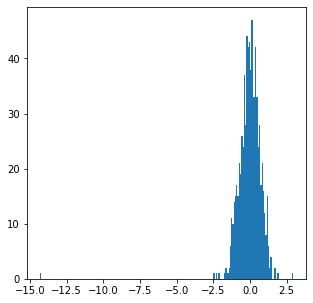

time: 406 ms (started: 2021-05-18 00:06:04 +03:00)


In [63]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(5,5))
plt.hist(vec, bins=200)
plt.show()

In [64]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 15, 768])
time: 0 ns (started: 2021-05-18 00:06:05 +03:00)


In [65]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 15, 768])

time: 0 ns (started: 2021-05-18 00:06:05 +03:00)


In [66]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 15, 768])

time: 0 ns (started: 2021-05-18 00:06:05 +03:00)


In [67]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([15, 13, 768])

time: 0 ns (started: 2021-05-18 00:06:06 +03:00)


## Word vectors

To give you some examples, let’s create word vectors two ways.


First, let’s <b>concatenate</b> the last four layers, giving us a single word vector per token. Each vector will have length `4 x 768 = 3,072`.

In [68]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 15 x 3072
time: 0 ns (started: 2021-05-18 00:06:07 +03:00)


As an alternative method, let’s try creating the word vectors by <b>summing</b> together the last four layers.

In [69]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 15 x 768
time: 0 ns (started: 2021-05-18 00:06:08 +03:00)


Посмотрим на вектора слова `замок`

In [70]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 париж
2 франци
3 ##я
4 москв
5 ##а
6 россия
7 берлин
8 герман
9 ##ия
10 афин
11 ##ы
12 гре
13 ##ция
14 [SEP]
time: 0 ns (started: 2021-05-18 00:06:09 +03:00)


Айдишники пар: 1-3, 6-9, 11-13.

In [21]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[18])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[42])

diff_bank2 = 1 - cosine(token_vecs_sum[42], token_vecs_sum[18])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank2)

IndexError: list index out of range

time: 906 ms (started: 2021-05-17 23:35:56 +03:00)


In [22]:
paris_emb = token_embeddings[1][-1].numpy()
france_emb = token_embeddings[3][-1].numpy()
moscow_emb = token_embeddings[6][-1].numpy()
russia_emb = token_embeddings[9][-1].numpy()
berlin_emb = token_embeddings[11][-1].numpy()
germany_emb = token_embeddings[13][-1].numpy()

time: 0 ns (started: 2021-05-17 23:36:03 +03:00)


In [23]:
paris_emb = token_vecs_sum[1].numpy()
france_emb = token_vecs_sum[3].numpy()
moscow_emb = token_vecs_sum[6].numpy()
russia_emb = token_vecs_sum[9].numpy()
berlin_emb = token_vecs_sum[11].numpy()
germany_emb = token_vecs_sum[13].numpy()

time: 0 ns (started: 2021-05-17 23:36:06 +03:00)


In [24]:
test = pd.DataFrame()

time: 0 ns (started: 2021-05-17 23:36:13 +03:00)


In [25]:
test = test.append(pd.Series(paris_emb),ignore_index=True)
test = test.append(pd.Series(france_emb),ignore_index=True)
test = test.append(pd.Series(moscow_emb),ignore_index=True)
test = test.append(pd.Series(russia_emb),ignore_index=True)
test = test.append(pd.Series(berlin_emb),ignore_index=True)
test = test.append(pd.Series(germany_emb),ignore_index=True)

time: 31 ms (started: 2021-05-17 23:36:13 +03:00)


In [26]:
test

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,2.925426,-0.002606,0.257144,-0.918334,-1.226854,-1.323437,-2.341635,0.120667,3.695042,2.979430,...,2.048784,-1.854114,-0.839798,0.347925,0.526800,0.298551,0.532887,3.143254,2.136284,-0.850823
1,-3.632020,-0.292483,-3.434539,-0.488579,-3.161268,2.685164,3.160190,2.469864,0.184783,-4.445290,...,-1.580536,-3.723154,-2.356267,-2.446170,-4.773803,-0.115674,0.935889,2.759530,4.560506,0.553206
2,0.192118,-1.258762,-0.034926,-0.829414,0.965826,-1.846236,-3.569152,3.484209,5.934809,0.420880,...,-1.717127,-3.790481,-8.636160,-0.609554,-2.111256,-0.075144,-1.588392,2.339371,2.315036,2.791941
3,2.162953,-2.139005,0.729216,1.644079,-3.004846,-1.880883,-3.571829,2.122722,3.854790,4.685766,...,-2.334403,-1.577250,-1.690584,-0.422078,0.816165,0.027466,-3.026695,4.149204,1.945156,1.660638
4,2.838804,-0.619159,-0.583541,2.357701,-2.646415,-3.364686,-3.775199,3.184202,2.958174,1.742435,...,-1.998667,3.360175,-2.388501,-1.015291,0.462935,-2.815777,-3.372399,4.317580,3.731174,-0.431742
5,-0.060054,-2.802578,3.571707,0.707181,-3.271389,0.481395,-0.419576,1.030157,2.489732,6.633072,...,-3.909411,0.630305,-5.529424,-1.519608,1.847181,-2.900807,0.703231,4.039372,3.847372,-1.646594


time: 31 ms (started: 2021-05-17 23:36:13 +03:00)


In [27]:
pca = PCA(n_components=2)
pca.fit_transform(test)

array([[ 30.879917 , -39.13547  ],
       [ 38.65227  ,  39.73901  ],
       [  8.95285  ,   6.313859 ],
       [ -3.729065 , -18.64156  ],
       [-36.91932  , -10.8382435],
       [-37.83665  ,  22.562393 ]], dtype=float32)

time: 78 ms (started: 2021-05-17 23:36:14 +03:00)


In [28]:
test = pca.fit_transform(test)

time: 15 ms (started: 2021-05-17 23:36:21 +03:00)


In [29]:
x = [row[0] for row in test]
y = [row[1] for row in test]
names = ['Париж', 'Франция', 'Москва', 'Россия', 'Берлин','Германия']

time: 0 ns (started: 2021-05-17 23:36:21 +03:00)


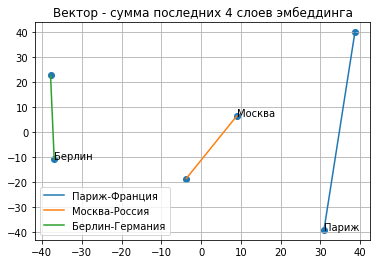

time: 250 ms (started: 2021-05-17 23:36:21 +03:00)


In [30]:
plt.scatter(x,y)
plt.plot([ 30.879972 , 38.652176 ],[ -39.135414  , 39.739037 ],label='Париж-Франция')
plt.plot([ 8.952813 , -3.7290246 ],[ 6.3138723  , -18.641552 ],label='Москва-Россия')
plt.plot([  -36.919296 , -37.836678 ],[ -10.8382845  , 22.562326 ],label='Берлин-Германия')
plt.text(30.879972, -39.135414, 'Париж', fontsize=10)
plt.text(8.952813, 6.3138723, 'Москва', fontsize=10)
plt.text(-36.919296, -10.8382845, 'Берлин', fontsize=10)
plt.title('Вектор - сумма последних 4 слоев эмбеддинга')
plt.grid()
plt.legend()

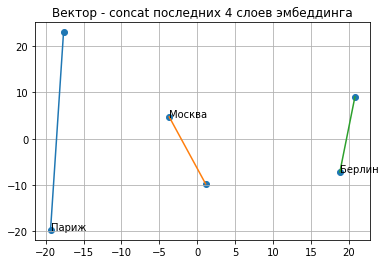

time: 156 ms (started: 2021-05-17 21:52:47 +03:00)


In [49]:
plt.scatter(x,y)
plt.plot([-19.364147 , -17.649271 ],[ -19.66722  , 22.915379 ])
plt.plot([ -3.7027702 , 1.093362 ],[ 4.680455  , -9.721635 ])
plt.plot([  18.819164 , 20.803669 ],[ -7.1852574  , 8.97827 ])
plt.text(-19.364147, -19.66722, 'Париж', fontsize=10)
plt.text(-3.7027702, 4.680455, 'Москва', fontsize=10)
plt.text(18.819164, -7.1852574, 'Берлин', fontsize=10)
plt.title('Вектор - concat последних 4 слоев эмбеддинга')
plt.grid()

### Попробуем работает ли пропорциональная аналогия

In [31]:
paris_emb = token_vecs_sum[1].numpy()
france_emb = token_vecs_sum[3].numpy()
moscow_emb = token_vecs_sum[6].numpy()
russia_emb = token_vecs_sum[9].numpy()
berlin_emb = token_vecs_sum[11].numpy()
germany_emb = token_vecs_sum[13].numpy()

time: 0 ns (started: 2021-05-17 23:36:26 +03:00)


In [32]:
argmax = 0
imax = 0

for i in range(len(token_vecs_sum)):
    
    if (i not in [1,3,11,0,30]):
        res = 1 - cosine(token_vecs_sum[i], (token_vecs_sum[3] - token_vecs_sum[1] + token_vecs_sum[11]))
        
        if (res > argmax):
            argmax = res
            imax = i
            
print(tokenized_text[imax])
if (imax == 13):
    print('Аналогия успешно найдена! Германия')

герман
Аналогия успешно найдена! Германия
time: 0 ns (started: 2021-05-17 23:36:27 +03:00)


In [33]:
argmax = 0
imax = 0

for i in range(len(token_vecs_sum)):
    
    if (i not in [3,11,13,0,30]):
        res = 1 - cosine(token_vecs_sum[i], (token_vecs_sum[11] - token_vecs_sum[13] + token_vecs_sum[3]))
        
        if (res > argmax):
            argmax = res
            imax = i

print('Правильный ответ - Париж')             
print(tokenized_text[imax])

Правильный ответ - Париж
россия
time: 0 ns (started: 2021-05-17 23:36:28 +03:00)


In [34]:
argmax = 0
imax = 0

for i in range(len(token_vecs_sum)):
    
    if (i not in [9,11,13,0,30]):
        res = 1 - cosine(token_vecs_sum[i], (token_vecs_sum[11] - token_vecs_sum[13] + token_vecs_sum[9]))
        
        if (res > argmax):
            argmax = res
            imax = i

print('Правильный ответ - Москва')            
print(tokenized_text[imax])

Правильный ответ - Москва
париж
time: 0 ns (started: 2021-05-17 23:36:29 +03:00)


In [35]:
argmax = 0
imax = 0

for i in range(len(token_vecs_sum)):
    
    if (i not in [9,6,3,0,30]):
        res = 1 - cosine(token_vecs_sum[i], (token_vecs_sum[9] - token_vecs_sum[6] + token_vecs_sum[3]))
        
        if (res > argmax):
            argmax = res
            imax = i

print('Правильный ответ - Париж')             
print(tokenized_text[imax])

Правильный ответ - Париж
париж
time: 0 ns (started: 2021-05-17 23:36:32 +03:00)


## Тестирую, что будет, если просто передать слова через пробел

In [19]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased",output_hidden_states = True)

time: 11.1 s (started: 2021-05-19 00:27:12 +03:00)


In [20]:
# Предложение с двумя понятиями слова "замок"
#text1 = "Париж, Франция, Москва, Россия, Берлин, Германия - что-то из этого страны, что-то - их столицы."

text1 = "Париж Франция Москва Россия Берлин Германия Афины Греция Лондон Англия Мадрид Испания"

text2 = "Когда я был в Париже, я забирался на Эйфелеву башню."

text3 = "Оттуда очень красивый вид на ночной Париж."

# Add the special tokens.
marked_text = "[CLS] " + text1 + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
париж        25,095
франци       53,481
##я             878
москв        60,718
##а             626
россия       13,813
берлин       41,548
герман       42,517
##ия          1,577
афин         44,113
##ы             880
гре          103,831
##ция         3,364
лонд         20,055
##он          1,503
англ          8,660
##ия          1,577
мадрид       35,512
испан        14,805
##ия          1,577
[SEP]           102
time: 593 ms (started: 2021-05-19 00:27:27 +03:00)


In [21]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
time: 0 ns (started: 2021-05-19 00:27:31 +03:00)


In [22]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

time: 0 ns (started: 2021-05-19 00:27:31 +03:00)


In [23]:
tokens_tensor

tensor([[   101,  25095,  53481,    878,  60718,    626,  13813,  41548,  42517,
           1577,  44113,    880, 103831,   3364,  20055,   1503,   8660,   1577,
          35512,  14805,   1577,    102]])

time: 563 ms (started: 2021-05-19 00:27:32 +03:00)


In [24]:
segments_tensors

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

time: 0 ns (started: 2021-05-19 00:27:32 +03:00)


In [25]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

time: 3.22 s (started: 2021-05-19 00:27:34 +03:00)


In [26]:
len(hidden_states)

13

time: 0 ns (started: 2021-05-19 00:27:37 +03:00)


In [27]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768
time: 0 ns (started: 2021-05-19 00:27:38 +03:00)


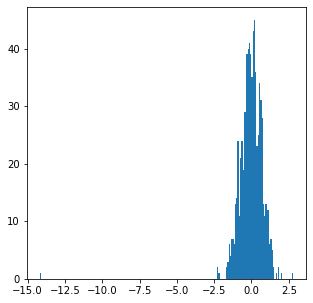

time: 6.78 s (started: 2021-05-19 00:27:38 +03:00)


In [28]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(5,5))
plt.hist(vec, bins=200)
plt.show()

In [29]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 22, 768])
time: 0 ns (started: 2021-05-19 00:27:44 +03:00)


In [30]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 22, 768])

time: 125 ms (started: 2021-05-19 00:27:44 +03:00)


In [31]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 22, 768])

time: 15 ms (started: 2021-05-19 00:27:45 +03:00)


In [32]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([22, 13, 768])

time: 0 ns (started: 2021-05-19 00:27:45 +03:00)


## Word vectors

To give you some examples, let’s create word vectors two ways.


First, let’s <b>concatenate</b> the last four layers, giving us a single word vector per token. Each vector will have length `4 x 768 = 3,072`.

In [33]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 22 x 3072
time: 47 ms (started: 2021-05-19 00:27:45 +03:00)


As an alternative method, let’s try creating the word vectors by <b>summing</b> together the last four layers.

In [34]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 22 x 768
time: 32 ms (started: 2021-05-19 00:27:45 +03:00)


Посмотрим на вектора слова `замок`

In [35]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

0 [CLS]
1 париж
2 франци
3 ##я
4 москв
5 ##а
6 россия
7 берлин
8 герман
9 ##ия
10 афин
11 ##ы
12 гре
13 ##ция
14 лонд
15 ##он
16 англ
17 ##ия
18 мадрид
19 испан
20 ##ия
21 [SEP]
time: 16 ms (started: 2021-05-19 00:27:45 +03:00)


Айдишники пар: 1-2, 4-6, 7-8, 10-12, 14-16, 18-19.

In [109]:
# а возьмем предпоследний

paris_emb = token_embeddings[1][-2].numpy()
france_emb = token_embeddings[2][-2].numpy()
moscow_emb = token_embeddings[4][-2].numpy()
russia_emb = token_embeddings[6][-2].numpy()
berlin_emb = token_embeddings[7][-2].numpy()
germany_emb = token_embeddings[8][-2].numpy()
athens_emb = token_embeddings[10][-2].numpy()
greece_emb = token_embeddings[12][-2].numpy() + token_embeddings[12][-2].numpy()

time: 0 ns (started: 2021-05-18 00:25:10 +03:00)


In [36]:
paris_emb = token_vecs_sum[1].numpy()
france_emb = token_vecs_sum[2].numpy()
moscow_emb = token_vecs_sum[4].numpy()
russia_emb = token_vecs_sum[6].numpy()
berlin_emb = token_vecs_sum[7].numpy()
germany_emb = token_vecs_sum[8].numpy()
athens_emb = token_vecs_sum[10].numpy()
greece_emb = token_vecs_sum[12].numpy()
#greece_emb = token_vecs_sum[12].numpy() + token_vecs_sum[13].numpy()
london_emb = token_vecs_sum[14].numpy()
england_emb = token_vecs_sum[16].numpy()
madrid_emb = token_vecs_sum[18].numpy()
spain_emb = token_vecs_sum[19].numpy()

time: 0 ns (started: 2021-05-19 00:27:54 +03:00)


In [37]:
test = pd.DataFrame()

time: 625 ms (started: 2021-05-19 00:27:56 +03:00)


In [38]:
test = test.append(pd.Series(paris_emb),ignore_index=True)
test = test.append(pd.Series(france_emb),ignore_index=True)
test = test.append(pd.Series(moscow_emb),ignore_index=True)
test = test.append(pd.Series(russia_emb),ignore_index=True)
test = test.append(pd.Series(berlin_emb),ignore_index=True)
test = test.append(pd.Series(germany_emb),ignore_index=True)
test = test.append(pd.Series(athens_emb),ignore_index=True)
test = test.append(pd.Series(greece_emb),ignore_index=True)
test = test.append(pd.Series(london_emb),ignore_index=True)
test = test.append(pd.Series(england_emb),ignore_index=True)
test = test.append(pd.Series(madrid_emb),ignore_index=True)
test = test.append(pd.Series(spain_emb),ignore_index=True)

time: 766 ms (started: 2021-05-19 00:27:57 +03:00)


In [39]:
test

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.003114,-2.058001,-1.394311,0.121295,0.481300,-3.246455,-1.235075,-0.186147,0.808198,2.166018,...,-2.890276,-2.577757,-3.301895,1.102910,0.325077,0.737481,-3.034222,0.676974,1.861386,-2.576355
1,-0.736797,1.053958,-1.872405,0.089941,2.680049,1.168334,-0.619913,0.025099,-0.016552,-0.350928,...,-0.657748,-1.897073,-1.382324,0.721138,-2.237031,1.139206,-1.238804,2.343306,1.912787,-2.816941
2,-2.028959,-0.159111,-1.674458,0.642370,3.422942,0.188494,-0.981709,2.635972,6.301226,1.055593,...,-1.232975,-5.201823,-8.846484,0.055697,0.609739,-0.041781,-3.461908,3.483282,1.828532,0.291707
3,-1.605073,0.737740,-0.758754,1.793325,1.093732,2.617974,-0.795928,-0.460808,2.374045,-0.489695,...,-1.880772,-1.139619,-1.952205,1.105665,2.290243,3.387191,-1.443761,4.199044,1.107644,-1.328255
4,2.473841,0.027713,-1.386068,-1.255533,1.863845,-1.261865,-1.837558,-1.990492,-1.407757,-1.843037,...,-3.439919,0.747018,-4.045298,1.762781,1.774979,0.832239,-2.686106,4.528450,2.822947,-2.331383
5,0.955934,-0.692006,3.026168,-1.257527,0.829290,2.476984,-1.960615,-0.146613,2.261358,3.023014,...,-3.254135,-0.114003,-8.019578,0.905147,2.179380,-1.133929,-1.279347,5.666100,2.520435,0.111071
6,-0.929565,-1.762680,-1.073046,-0.229176,1.906949,-1.126096,-1.736734,-1.605492,4.262747,2.260285,...,-3.197547,-3.784966,-5.040825,1.408026,2.647895,-1.416710,-2.120019,3.456564,2.346672,1.706025
7,0.198675,-2.381216,-1.512520,-1.023841,-1.717209,2.308709,-1.834813,0.459084,1.178109,1.582245,...,-0.087142,-0.614625,-4.257168,4.386248,-0.880887,0.802092,1.299619,0.757023,1.295540,-3.391660
8,0.120019,-0.720249,-1.626442,-0.907965,4.172873,-2.351714,0.557654,-1.415269,1.794093,3.812435,...,0.376172,1.879353,-7.262979,1.159599,2.803829,0.895356,0.965803,0.759411,-0.482064,-0.524331
9,0.133684,0.390715,1.008427,-1.782830,1.859775,-0.469254,-3.527579,1.430483,1.626101,4.431969,...,-2.675090,-1.694160,-6.058403,-1.410010,2.552769,-0.550392,-3.237615,4.454701,2.439511,-0.723678


time: 750 ms (started: 2021-05-19 00:27:57 +03:00)


In [40]:
pca = PCA(n_components=2)
pca.fit_transform(test)

array([[-30.203781  ,  -3.6722746 ],
       [-15.262738  , -35.195965  ],
       [-24.184164  , -16.006832  ],
       [-29.568815  ,  14.122827  ],
       [-17.419361  ,  21.73815   ],
       [ 17.067547  , -15.833472  ],
       [  0.23184536,  -0.7182147 ],
       [  8.450757  ,  -1.3241204 ],
       [  6.6486306 ,  10.514126  ],
       [ 34.264526  ,  -6.955546  ],
       [ 11.102631  ,  39.056942  ],
       [ 38.872894  ,  -5.725602  ]], dtype=float32)

time: 1.06 s (started: 2021-05-19 00:27:59 +03:00)


In [41]:
test = pca.fit_transform(test)

time: 16 ms (started: 2021-05-19 00:28:04 +03:00)


In [42]:
x = [row[0] for row in test]
y = [row[1] for row in test]
names = ['Париж', 'Франция', 'Москва', 'Россия', 'Берлин','Германия', 'Афины','Греция',
        'Лондон','A','Мадрид','И']

time: 15 ms (started: 2021-05-19 00:28:04 +03:00)


In [166]:
analogies=['Париж-Франция', 'Москва-Россия', 'Берлин-Германия', 'Афины-Греция']

time: 0 ns (started: 2021-05-18 00:40:31 +03:00)


In [45]:
idxes = (0,2,4,6,8,10)

time: 0 ns (started: 2021-05-19 00:29:00 +03:00)


Text(0, 0.5, 'Координата y (RuBERT)')

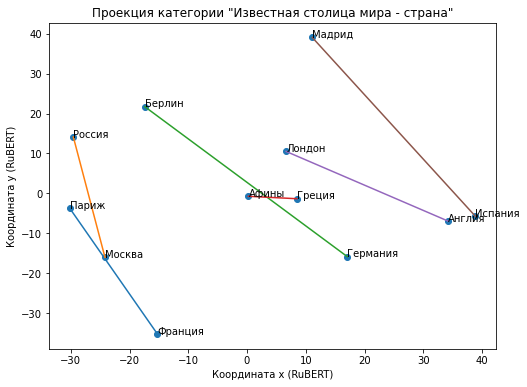

time: 234 ms (started: 2021-05-19 00:35:57 +03:00)


In [55]:
plt.figure(figsize=(8,6))

plt.scatter(x,y)
for i in idxes:
    plt.plot([test[i][0],test[i+1][0]], [test[i][1], test[i+1][1]], label=names[i])

    
    
plt.text(-15.262738  , -35.195965, 'Франция', fontsize=10)
plt.text(-30.203781  ,  -3.6722746, 'Париж', fontsize=10)
plt.text(-29.568815  ,  14.122827, 'Россия', fontsize=10)
plt.text(-24.184164  , -16.006832, 'Москва', fontsize=10)
plt.text(17.067547  , -15.833472, 'Германия', fontsize=10)
plt.text(-17.419361  ,  21.73815, 'Берлин', fontsize=10)
plt.text(38.872894  ,  -5.725602, 'Испания', fontsize=10)
plt.text(11.102631  ,  39.056942, 'Мадрид', fontsize=10)
plt.text(8.450757  ,  -1.3241204, 'Греция', fontsize=10)
plt.text(0.23184536,  -0.7182147, 'Афины', fontsize=10)
plt.text(34.264526  ,  -6.955546, 'Англия', fontsize=10)
plt.text(6.6486306 ,  10.514126, 'Лондон', fontsize=10)
plt.title('Проекция категории "Известная столица мира - страна"')
#plt.grid()
plt.xlabel('Координата х (RuBERT)')
plt.ylabel('Координата y (RuBERT)')

#plt.grid()
#plt.legend()

Айдишники пар: 1-2, 4-6, 7-8, 10-12, 14-16, 18-19.

In [174]:
len(token_vecs_sum)

22

time: 0 ns (started: 2021-05-18 00:54:46 +03:00)


In [52]:
#argmax = 0
#imax = 0

word_1 = [4,7,10,14,18]
word_2 = [6,8,12,16,19]

print('Looking for Париж\n')
for i in range(len(word_1)):
    print(tokenized_text[word_1[i]], '-', 
          tokenized_text[word_2[i]], '+', tokenized_text[2])
    
    argmax = 0
    imax = 0
    for word_id in range(len(token_vecs_sum)):
        
        if (word_id not in [word_1[i],word_2[i],2,0,21]):
            res = 1 - cosine(token_vecs_sum[word_id], (token_vecs_sum[word_1[i]] - token_vecs_sum[word_2[i]] + token_vecs_sum[2]))
        
            if (res > argmax):
                argmax = res
                imax = word_id
    
    true_res = 1 - cosine(token_vecs_sum[1], (token_vecs_sum[word_1[i]] - token_vecs_sum[word_2[i]] + token_vecs_sum[2]))
    print('True argmax = ', true_res)
    
    print('Найденное слово ', tokenized_text[imax])
    print(argmax)
    print('')
                


Looking for Париж

москв - россия + франци
True argmax =  0.5486891269683838
Найденное слово  париж
0.5486891269683838

берлин - герман + франци
True argmax =  0.6306568384170532
Найденное слово  ##я
0.6472331881523132

афин - гре + франци
True argmax =  0.5188661813735962
Найденное слово  москв
0.6425675749778748

лонд - англ + франци
True argmax =  0.6301726698875427
Найденное слово  париж
0.6301726698875427

мадрид - испан + франци
True argmax =  0.6278064250946045
Найденное слово  ##я
0.6624007821083069

time: 63 ms (started: 2021-05-19 00:34:31 +03:00)


In [53]:
#argmax = 0
#imax = 0

word_1 = [4,1,10,14,18]
word_2 = [6,2,12,16,19]

print('Looking for Берлин\n')
for i in range(len(word_1)):
    print(tokenized_text[word_1[i]], '-', 
          tokenized_text[word_2[i]], '+', tokenized_text[8])
    
    argmax = 0
    imax = 0
    for word_id in range(len(token_vecs_sum)):
        
        if (word_id not in [word_1[i],word_2[i],8,0,21]):
            res = 1 - cosine(token_vecs_sum[word_id], (token_vecs_sum[word_1[i]] - token_vecs_sum[word_2[i]] + token_vecs_sum[8]))
        
            if (res > argmax):
                argmax = res
                imax = word_id
    
    true_res = 1 - cosine(token_vecs_sum[7], (token_vecs_sum[word_1[i]] - token_vecs_sum[word_2[i]] + token_vecs_sum[8]))
    print('True argmax = ', true_res)
    
    print('Найденное слово ', tokenized_text[imax])
    print(argmax)
    print('')

Looking for Берлин

москв - россия + герман
True argmax =  0.5028237104415894
Найденное слово  англ
0.6704373955726624

париж - франци + герман
True argmax =  0.6480290293693542
Найденное слово  берлин
0.6480290293693542

афин - гре + герман
True argmax =  0.6163378357887268
Найденное слово  англ
0.6185653209686279

лонд - англ + герман
True argmax =  0.6861370801925659
Найденное слово  афин
0.7090265154838562

мадрид - испан + герман
True argmax =  0.7918646931648254
Найденное слово  берлин
0.7918646931648254

time: 31 ms (started: 2021-05-19 00:34:32 +03:00)


In [54]:
#argmax = 0
#imax = 0

word_1 = [4,1,10,14,7]
word_2 = [6,2,12,16,8]

print('Looking for Мадрид\n')
for i in range(len(word_1)):
    print(tokenized_text[word_1[i]], '-', 
          tokenized_text[word_2[i]], '+', tokenized_text[19])
    
    argmax = 0
    imax = 0
    for word_id in range(len(token_vecs_sum)):
        
        if (word_id not in [word_1[i],word_2[i],19,0,21]):
            res = 1 - cosine(token_vecs_sum[word_id], (token_vecs_sum[word_1[i]] - token_vecs_sum[word_2[i]] + token_vecs_sum[19]))
        
            if (res > argmax):
                argmax = res
                imax = word_id
    
    true_res = 1 - cosine(token_vecs_sum[18], (token_vecs_sum[word_1[i]] - token_vecs_sum[word_2[i]] + token_vecs_sum[19]))
    print('True argmax = ', true_res)
    
    print('Найденное слово ', tokenized_text[imax])
    print(argmax)
    print('')

Looking for Мадрид

москв - россия + испан
True argmax =  0.5163750648498535
Найденное слово  англ
0.7250609993934631

париж - франци + испан
True argmax =  0.6556596755981445
Найденное слово  англ
0.6784156560897827

афин - гре + испан
True argmax =  0.6154543161392212
Найденное слово  англ
0.6988268494606018

лонд - англ + испан
True argmax =  0.6692520976066589
Найденное слово  афин
0.6709465980529785

берлин - герман + испан
True argmax =  0.7918150424957275
Найденное слово  мадрид
0.7918150424957275

time: 16 ms (started: 2021-05-19 00:34:32 +03:00)
